<h1>Prerequisites</h1>

In [49]:
# utilities
import os
import re
import numpy as np
import pandas as pd
import openpyxl

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sid = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()

# sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# gensim
import gensim
from gensim import corpora, models

<h1>Reading Dataset</h1>

In [50]:
main_dir = os.getcwd()
dataset_path = os.path.join(main_dir, "Dataset.xlsx")
df = pd.read_excel(dataset_path)

<h1>Defining Functions</h1>

In [51]:
def lower_case(text):
    
    return text.lower()

In [52]:
def remove_urls(text):
    
    return re.sub(r'http\S+', '', text)

In [53]:
def remove_special_characters(text):

    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [54]:
def remove_stopwords(text):
    
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    
    return ' '.join([word for word in tokens if word.lower() not in stop_words])


In [55]:
def tokenize(text):
    
    return word_tokenize(text)

In [56]:
def lemmatize_nltk(text):
    
    tokens = word_tokenize(text)
    
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

In [57]:
def preprocess_text(text):
    text = lower_case(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = lemmatize_nltk(text)
    return text


In [58]:
# Function to create a word cloud for a specific topic
def generate_wordcloud_for_topic(lda_model, topic_id, dictionary, tokenized_docs):
    topic_words = lda_model.show_topic(topic_id, topn=20)
    wordcloud_data = {word: weight for word, weight in topic_words}
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110,
                          background_color='white').generate_from_frequencies(wordcloud_data)

    # Display the word cloud for the topic using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.axis('off')
    plt.show()

<h1>Cleaning Text</h1>

In [59]:
df_no_duplicates = df.drop_duplicates(subset=['Handle', 'Tweet URL', 'Post Body'], keep='first')

In [60]:
df['Clean Tweet'] = df['Post Body'].apply(preprocess_text)

In [61]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Keep only rows with dates greater than or equal to October 1, 2023
df = df[df['Date'] >= '2023-10-01']

# Set the desired number of rows per date
desired_rows_per_date = 600

# Keep only the first 600 rows for each date
df = df.groupby('Date').head(desired_rows_per_date)

<h1>

In [62]:
df['Compound'] = df['Clean Tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['Sentiment'] = df['Compound'].apply(lambda c: 'Negative' if c <= -0.05 else 'Positive' if c >= 0.05 else 'Neutral')

In [63]:
df.drop(columns=['Name', 'Media URL', 'Retweets', 'Likes', 'Comments', 'Tweet URL', 'Timestamp', 'Profile Link', 'Handle', 'Views'], inplace= True)

<h1>Visualization Of Tweets</h1>

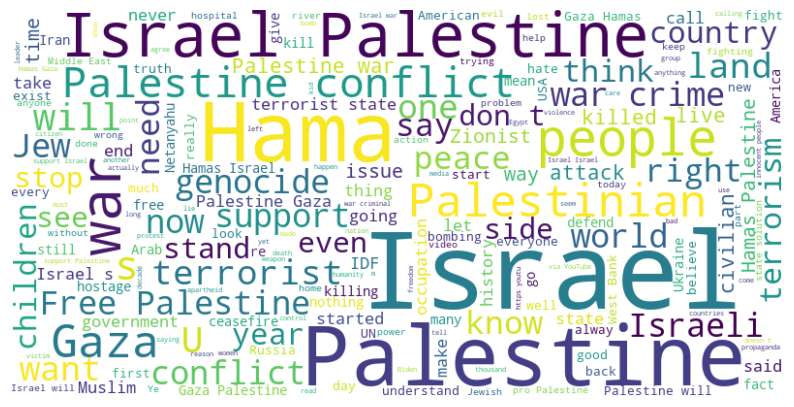

In [64]:
text = ' '.join(df['Post Body'].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [82]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Filter data for October 1, 2023, to November 30, 2023
filtered_df = df[(df['Date'] >= '2023-10-01') & (df['Date'] <= '2023-11-30')]

# Group posts by date using the 'Clean Tweet' column
grouped_by_date = filtered_df.groupby('Date')['Clean Tweet'].apply(list).reset_index()

# Lists to store keywords for each date
keywords_list = []

# Numbering for dominant topics
topic_number = 1

for date, documents in zip(grouped_by_date['Date'], grouped_by_date['Clean Tweet']):
    tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokenized_docs = [[word for word in doc if word.isalnum() and word not in stop_words] for doc in tokenized_docs]

    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=50)
    topics = lda_model.print_topics()

    # Extract keywords from the dominant topic
    dominant_topic = max(topics, key=lambda x: float(x[1].split('*')[0].strip()))
    keywords = [word.split('*')[1].strip().replace('"', '') for word in dominant_topic[1].split('+')]

    # Exclude common words across topics (e.g., words that appear in more than 2 topics)
    common_words = set()
    for other_topic in topics:
        if other_topic != dominant_topic:
            other_keywords = [word.split('*')[1].strip().replace('"', '') for word in other_topic[1].split('+')]
            common_words.update(set(keywords) & set(other_keywords))

    keywords = [word for word in keywords if word not in common_words]

    # Append the keywords along with the topic number
    keywords_list.append((date, topic_number, keywords))

    # Increment topic_number for the next iteration
    topic_number += 1

# Convert the list of keywords to a DataFrame
keywords_df = pd.DataFrame(keywords_list, columns=['Date', 'TopicNumber', 'Keywords'])

# Print keywords for each date
for index, row in keywords_df.iterrows():
    print(f"Date: {row['Date'].strftime('%m/%d/%y')}, Topic Number: {row['TopicNumber']}, Keywords: {', '.join(row['Keywords'])}")

Date: 10/01/23, Topic Number: 1, Keywords: terrorist, capital, jerusalem, make, occupied, eternal
Date: 10/02/23, Topic Number: 2, Keywords: free, terrorism, year
Date: 10/03/23, Topic Number: 3, Keywords: gaza, iraq, ukraine, dont, فلسطين, breaking
Date: 10/04/23, Topic Number: 4, Keywords: support, crime, think, peace
Date: 10/05/23, Topic Number: 5, Keywords: hamas, occupation, peace, state
Date: 10/06/23, Topic Number: 6, Keywords: one, censored, think
Date: 10/07/23, Topic Number: 7, Keywords: terrorism, pal, institution, jihad, solution, hamas
Date: 10/08/23, Topic Number: 8, Keywords: people, israeli, israelunderattack
Date: 10/09/23, Topic Number: 9, Keywords: israelpalestinewar, attack, israelunderattack, israeli
Date: 10/10/23, Topic Number: 10, Keywords: state
Date: 10/11/23, Topic Number: 11, Keywords: innocent
Date: 10/12/23, Topic Number: 12, Keywords: gaza, support, israeli
Date: 10/13/23, Topic Number: 13, Keywords: occupied, story, beautiful, explained
Date: 10/14/23, 

<h1>Visualization Of Trending Topics Overtime</h1>

<h1>Vectorizers</h1>

In [73]:
tfvectorizer = TfidfVectorizer()
countvectorizer = CountVectorizer()

<h1>Training Dataset</h1>

<h2>Naive Bayes</h2>

In [74]:
from sklearn.model_selection import GridSearchCV

# Split the data into training and testing sets 0.2 ratio 80% for training 20% for testing
train_data, test_data, train_labels, test_labels = train_test_split(df['Clean Tweet'].tolist(), df['Sentiment'], test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to a bag-of-words representation
X_train = countvectorizer.fit_transform(train_data)
X_test = countvectorizer.transform(test_data)

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Create the GridSearchCV object
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, train_labels)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Create a new model using the best hyperparameters
best_naive_bayes = MultinomialNB(alpha=best_alpha)
best_naive_bayes.fit(X_train, train_labels)

# Make predictions on the test set
predictions_nb = best_naive_bayes.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions_nb)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(test_labels, predictions_nb))
print(confusion_matrix(test_labels, predictions_nb))


Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.78      0.95      0.86      4316
     Neutral       0.47      0.15      0.23       409
    Positive       0.71      0.39      0.50      1407

    accuracy                           0.77      6132
   macro avg       0.66      0.50      0.53      6132
weighted avg       0.75      0.77      0.73      6132

[[4095   39  182]
 [ 309   63   37]
 [ 828   31  548]]


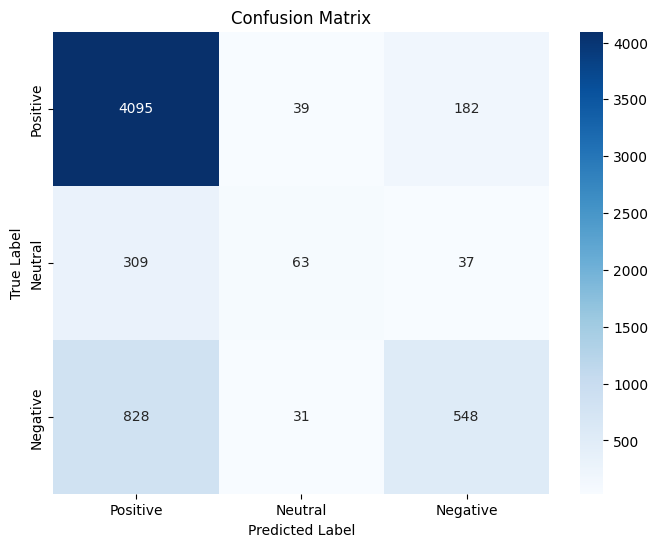

In [75]:
# Calculate confusion matrix without normalization
cm = confusion_matrix(test_labels, predictions_nb)

# Create a heatmap with correct orientation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<h2>Support Vector Machine</h2>

In [76]:
# Split the data into training and testing sets 0.2 ratio 80% for training 20% for testing
train_data, test_data, train_labels, test_labels = train_test_split(df['Clean Tweet'].tolist(), df['Sentiment'], test_size=0.2, random_state=42)

# Create a TF-IDF Vectorizer to convert text data to a numerical representation
tfvectorizer = TfidfVectorizer()
X_train = tfvectorizer.fit_transform(train_data)
X_test = tfvectorizer.transform(test_data)

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100]}

# Create and train the SVM model
svm_classifier = SVC(kernel='linear')

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, train_labels)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']

# Create a new SVM model with the best C
best_svm_classifier = SVC(kernel='linear', C=best_C)
best_svm_classifier.fit(X_train, train_labels)

# Make predictions on the test set
predictions_svm = best_svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions_svm)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(test_labels, predictions_svm))
print(confusion_matrix(test_labels, predictions_svm))

Accuracy: 0.83
              precision    recall  f1-score   support

    Negative       0.85      0.95      0.90      4316
     Neutral       0.69      0.21      0.32       409
    Positive       0.75      0.65      0.70      1407

    accuracy                           0.83      6132
   macro avg       0.77      0.60      0.64      6132
weighted avg       0.82      0.83      0.81      6132

[[4082   13  221]
 [ 243   85   81]
 [ 463   25  919]]


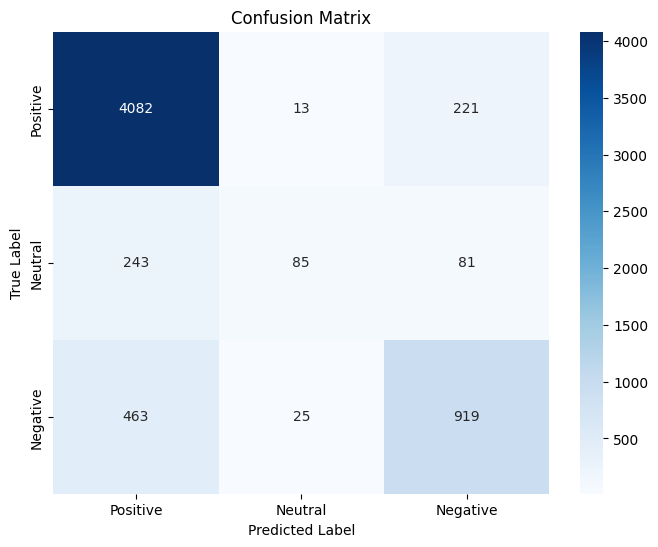

In [77]:
# Calculate confusion matrix without normalization
cm = confusion_matrix(test_labels, predictions_svm)

# Create a heatmap with correct orientation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<h2>Decision Tree</h2>

In [78]:
# Split the data into training and testing sets 0.2 ratio 80% for training 20% for testing
train_data, test_data, train_labels, test_labels = train_test_split(df['Clean Tweet'].tolist(), df['Sentiment'], test_size=0.2, random_state=42)

X_train = countvectorizer.fit_transform(train_data)
X_test = countvectorizer.transform(test_data)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create and train the Decision Tree model
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(decision_tree_classifier, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new Decision Tree model with the best hyperparameters
best_decision_tree_classifier = DecisionTreeClassifier(random_state=42, **best_params)
best_decision_tree_classifier.fit(X_train, train_labels)

# Make predictions on the test set
predictions_dt = best_decision_tree_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions_dt)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(test_labels, predictions_dt))
print(confusion_matrix(test_labels, predictions_dt))

Accuracy: 0.77
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85      4316
     Neutral       0.48      0.47      0.48       409
    Positive       0.60      0.50      0.55      1407

    accuracy                           0.77      6132
   macro avg       0.64      0.62      0.63      6132
weighted avg       0.76      0.77      0.76      6132

[[3788  117  411]
 [ 153  194   62]
 [ 607   91  709]]


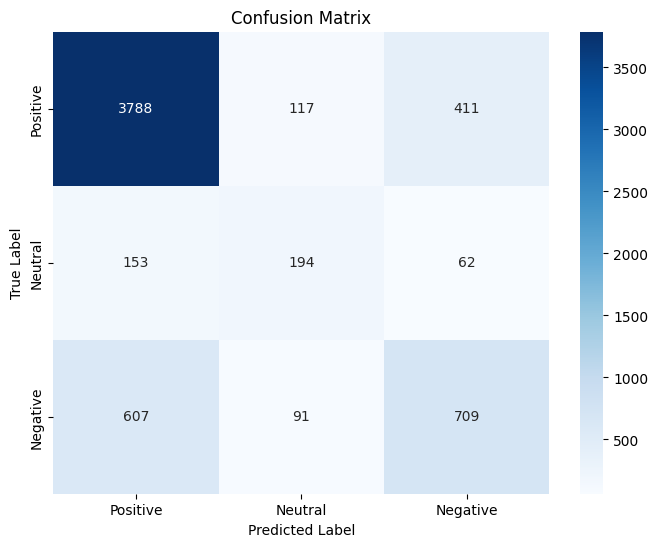

In [79]:
# Calculate confusion matrix without normalization
cm = confusion_matrix(test_labels, predictions_dt)

# Create a heatmap with correct orientation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


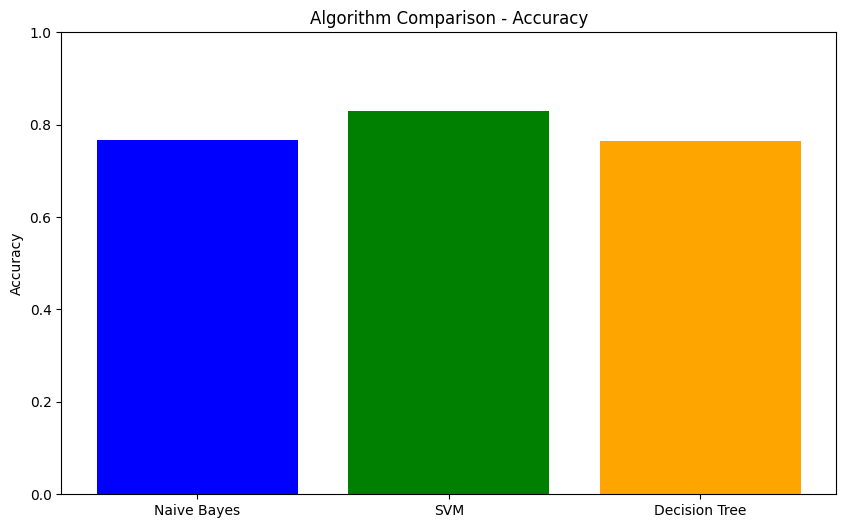

In [80]:
algorithms = ['Naive Bayes', 'SVM', 'Decision Tree']

accuracies = [accuracy_score(test_labels, predictions_nb),
              accuracy_score(test_labels, predictions_svm),
              accuracy_score(test_labels, predictions_dt)]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(algorithms)), accuracies, color=['blue', 'green', 'orange'])
plt.xticks(np.arange(len(algorithms)), algorithms)
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison - Accuracy')
plt.show()


C:\Users\Cian\AppData\Local\Temp\ipykernel_12136\1016438360.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


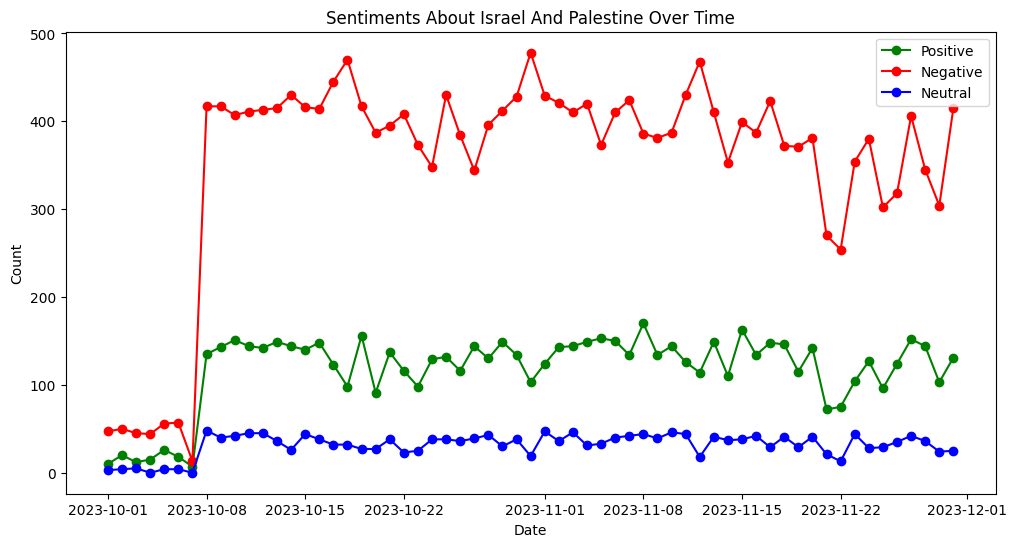

In [81]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Filter data for October 1, 2023, to November 30, 2023
filtered_df = df[(df['Date'] >= '2023-10-01') & (df['Date'] <= '2023-11-30')]

# Group posts by date and sentiment
grouped_by_date_sentiment = filtered_df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(grouped_by_date_sentiment['Date'], grouped_by_date_sentiment['Positive'], label='Positive', marker='o', linestyle='-', color='green')
plt.plot(grouped_by_date_sentiment['Date'], grouped_by_date_sentiment['Negative'], label='Negative', marker='o', linestyle='-', color='red')
plt.plot(grouped_by_date_sentiment['Date'], grouped_by_date_sentiment['Neutral'], label='Neutral', marker='o', linestyle='-', color='blue')

plt.title('Sentiments About Israel And Palestine Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()
